In [1]:
import glob as gb
import os
import scipy.io
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.applications.imagenet_utils import preprocess_input

In [2]:
w = 224
im_size = (w, w)
model_size = (w,w,3)



train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=0.4,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
       # brightness_range=[0.5, 0.5],
        channel_shift_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True)



test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)



train_generator = train_datagen.flow_from_directory('train', color_mode='rgb', class_mode='categorical', target_size=im_size)
validation_generator = test_datagen.flow_from_directory('val', color_mode='rgb', class_mode='categorical', target_size=im_size, shuffle=False)


Found 6551 images belonging to 102 classes.
Found 1638 images belonging to 102 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

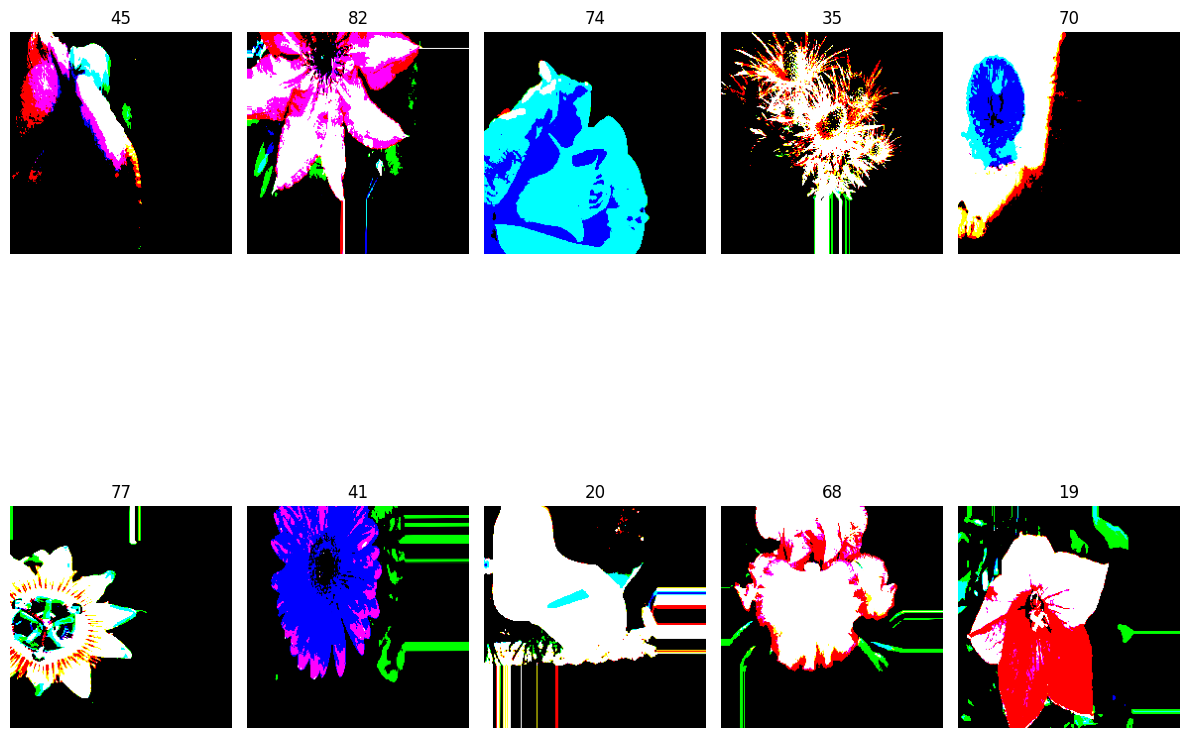

In [3]:
class_names = list(train_generator.class_indices.keys())  # قائمة أسماء الفئات
batch_size = 10
# عرض الصور وتصنيفها
fig, axs = plt.subplots(batch_size // 5, 5, figsize=(12, 12))
axs = axs.flatten()
z=0
for images, labels in train_generator:
    for i in range(batch_size):
        axs[i].imshow(images[i])
        axs[i].set_title(class_names[labels[i].argmax()])
        axs[i].axis('off')    
    break  # يتم استخدام الكود لعرض دفعة واحدة فقطif (z==64) : break<|endoftext|>

plt.tight_layout()
plt.show()


In [4]:
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=model_size)

for layer in conv_base.layers[:120]:
    layer.trainable = False
    
#conv_base.summary()

In [5]:
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(.3)) 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(102, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [7]:
from keras import optimizers

opt = optimizers.SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

learning_rate_reduction = callbacks=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.1, min_lr=1e-9)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=40, )

C:\Users\Elsoudy\anaconda3\envs\tfg\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:

history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=400, validation_data=(validation_generator), callbacks=[ EarlyStopping, learning_rate_reduction])

model.save('flowerres99.h5')

Epoch 1/400
205/205 [==============================] - 119s 530ms/step - loss: 3.6244 - accuracy: 0.2424 - precision: 0.8983 - recall: 0.0971 - val_loss: 1.5633 - val_accuracy: 0.6093 - val_precision: 0.8275 - val_recall: 0.4481 - lr: 0.0010
Epoch 2/400
205/205 [==============================] - 67s 326ms/step - loss: 1.4849 - accuracy: 0.6413 - precision: 0.9030 - recall: 0.4549 - val_loss: 0.6060 - val_accuracy: 0.8492 - val_precision: 0.9140 - val_recall: 0.7912 - lr: 0.0010
Epoch 3/400
205/205 [==============================] - 64s 310ms/step - loss: 0.7894 - accuracy: 0.7980 - precision: 0.9154 - recall: 0.6906 - val_loss: 0.3854 - val_accuracy: 0.9005 - val_precision: 0.9336 - val_recall: 0.8669 - lr: 0.0010
Epoch 4/400
205/205 [==============================] - 63s 309ms/step - loss: 0.5357 - accuracy: 0.8559 - precision: 0.9276 - recall: 0.7878 - val_loss: 0.3130 - val_accuracy: 0.9188 - val_precision: 0.9427 - val_recall: 0.9048 - lr: 0.0010
Epoch 5/400
205/205 [==============

In [9]:
model.evaluate(validation_generator)

52/52 [==============================] - 4s 80ms/step - loss: 0.1944 - accuracy: 0.9725 - precision: 0.9737 - recall: 0.9713


[0.19437268376350403,
 0.9725274443626404,
 0.9736841917037964,
 0.9713064432144165]

In [17]:
model.evaluate(train_generator)

205/205 [==============================] - 59s 285ms/step - loss: 0.0012 - accuracy: 0.9995 - precision: 0.9997 - recall: 0.9995


[0.0012421016581356525,
 0.9995420575141907,
 0.9996946454048157,
 0.9995420575141907]

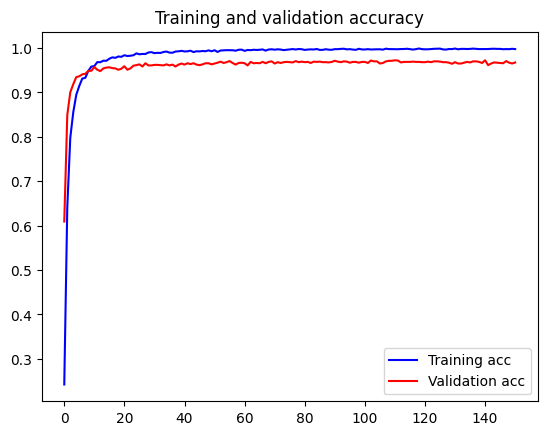

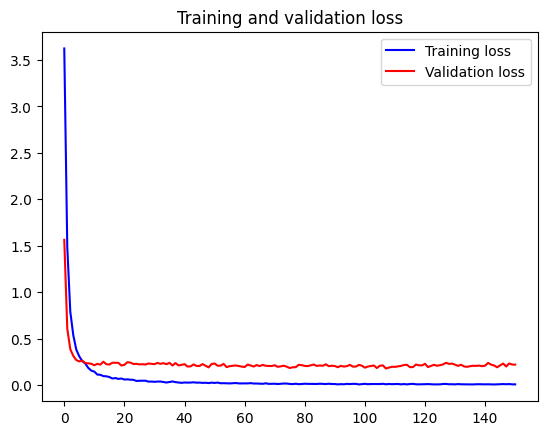

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

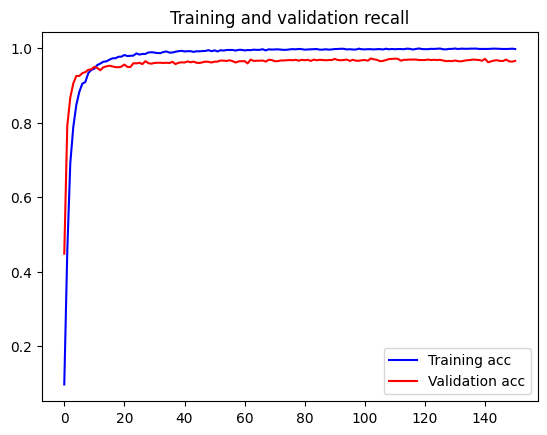

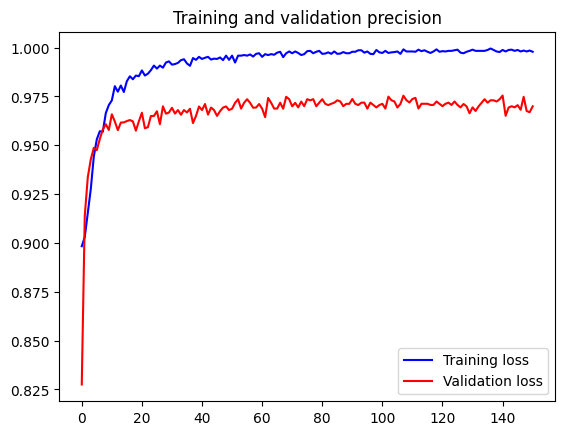

In [14]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['precision']
val_loss = history.history['val_precision']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation precision')
plt.legend()

plt.show()

52/52 [==============================] - 5s 81ms/step
[  0   0   0 ... 101 101 101] [  0   0   0 ... 101 101 101]


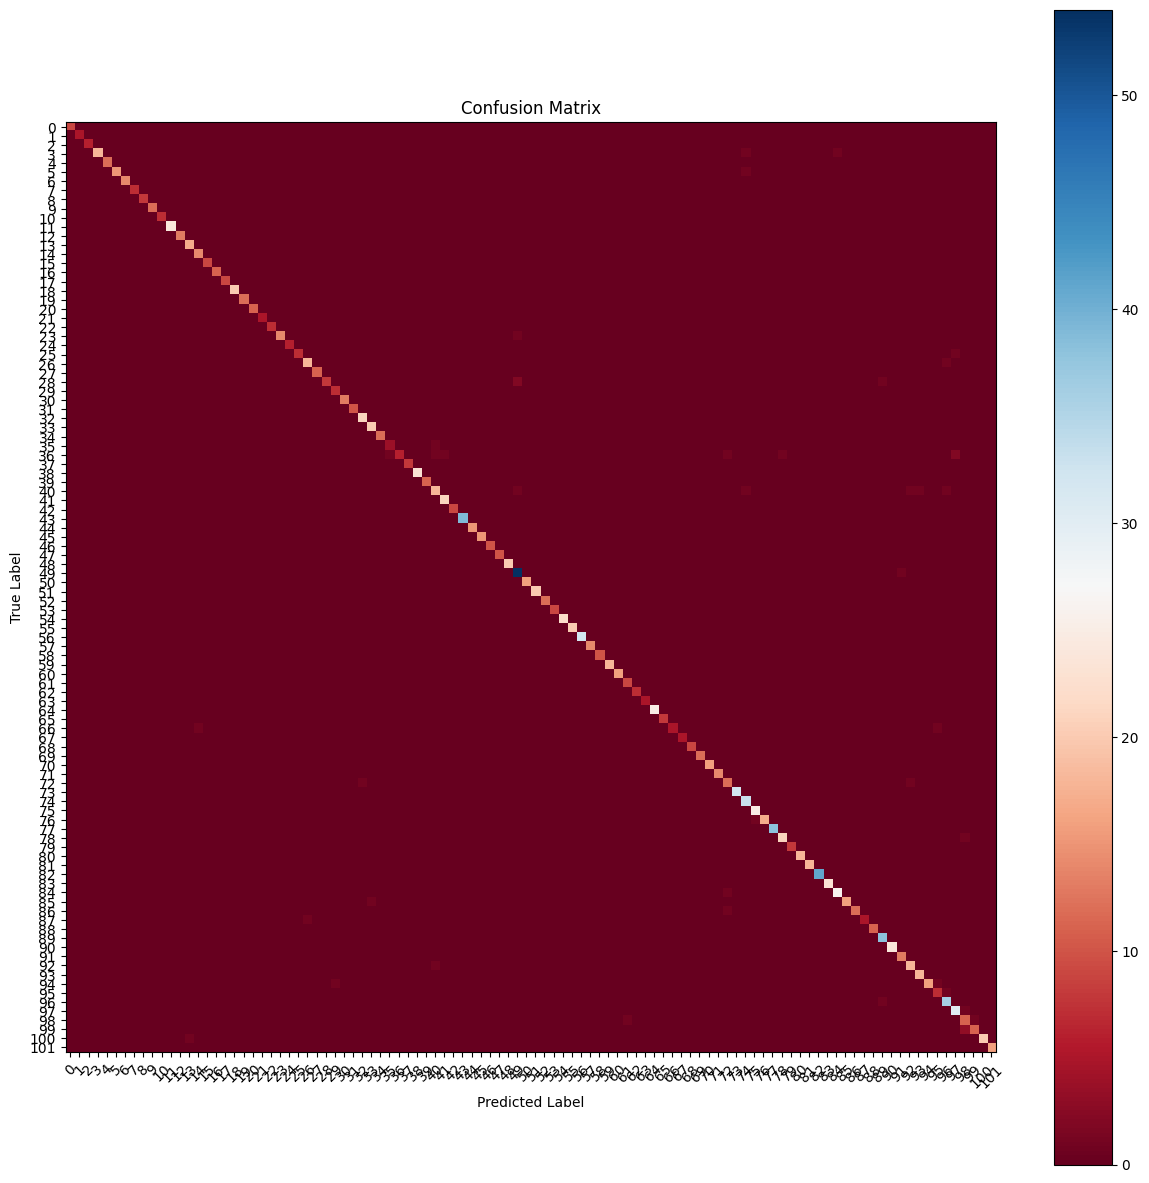

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
total_images = validation_generator.samples
num_classes = validation_generator.num_classes
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
cm = confusion_matrix(y_true, np.argmax(predictions, axis=1))

print(y_true, np.argmax(predictions, axis=1))


plt.figure(figsize=(15, 15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdBu)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks,  rotation=45)
plt.yticks(tick_marks )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()